In [450]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN, KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn import metrics

# Introdução

Para esse trabalho de clusterização utilizaremos dados de tipos de sementes de trigo, classificados em 3 tipos diferentes e com 7 atributos diferentes:

* Area
* Perimeter
* Compactness
* Kernel Length: Comprimento da Semente
* Kernel Width: Largura da Semente
* Asymmetry
* Kernel Groove Length
* Type -  Classificação do tipo de semente - Será útil para a validação

Os dados originais foram obtidos em https://archive.ics.uci.edu/ml/datasets/seeds

Para o trabalho realizamos um pré-processamento nos dados pois a formatação por coluna não estava correta.

In [395]:
df_original = pd.read_csv("seeds_dataset_treated.csv", sep=';', decimal='.')

In [396]:
df_original

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry,kernel_groove_length,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [397]:
df = df_original[df_original.columns[:-1]]
df_label = df_original["type"]

Em uma análise inicial dos dados, como possuímos diversos atributos será dificil interpretarmos de forma multidimensional o espaço dos clusters, então podemos analisar os pares de atributos para pelo menos termos uma noção básica de como se distribuem. Para isso usamos o gráfico PairPlot do Seaborn colorido pelo tipo.

Podemos ver que os tipos de semente são bem definidos para todos os conjuntos de dados, sem muita interseção entre eles. Isso é muito bom pois elimina a incerteza entre os clusters. Contudo, se percebermos, os clusters não são espacialmente separados entre si. Em grande maioria são sub-intervalos definidos. Isso pode se tornar um problema para algoritmos de classificação que dependem de proximidade dos pontos e não recebem uma quantidade inicial de clusters bem definida, é o exemplo do DBSCAN. Essa é uma hipótese inicial que vamos validar.

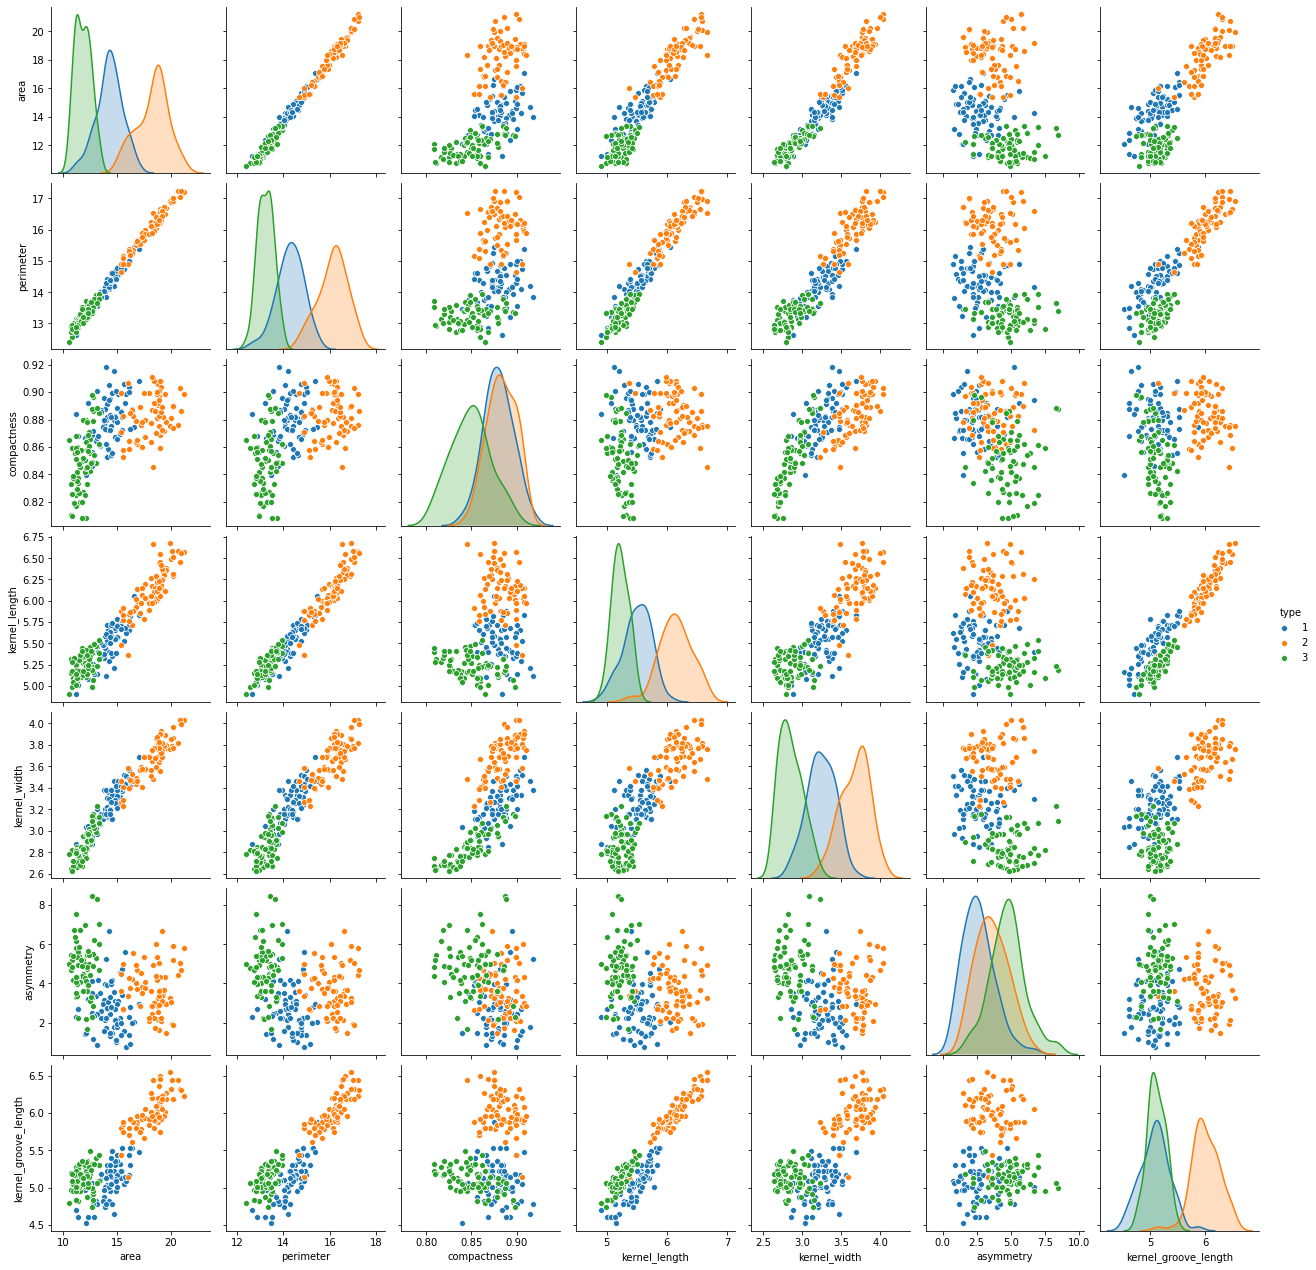

In [398]:
sns.pairplot(df_original, vars=df.columns, hue="type")

# Comparações

In [457]:
def matriz_contigencia(df_comparison):
    cm = pd.DataFrame(metrics.cluster.contingency_matrix(df_comparison['class'], df_comparison['cluster']), index=df_comparison['class'].unique(), columns=df_comparison['cluster'].unique())

    sns.heatmap(cm)
    plt.xlabel("Predicao")
    plt.ylabel("Tipo")

    for (x, y), value in np.ndenumerate(cm.T):
        plt.text(
            x+0.5, y+0.5, f"{value}", va="center", ha="center",
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'
        )
    )
    

### Comparativo de Métricas

Quando tratamos dados com labels de classificação, podemos obter as seguintes métricas:

* **Homogeneidade**: o ideal (1) é quando um cluster possui apenas membros de uma única classe.
* **Completude**: o ideal (1) é quando uma classe está definida apenas para membros do mesmo cluster.
* **V-Measure**: é a média harmônica entre homogeneidade e completude.

Explicamos mais sobre as métricas???????????????????? 

* **Fowlkes-Mallows**: mede a similaridade entre elementos dos mesmos clusters.
    
    $ \text{FMI} = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}} $

Para dados sem o conhecimento prévio dos labels, podemos usar as seguintes métricas:

* **Coeficiente de Silhouette**: mede a semelhança entre elementos do mesmo cluster em comparação com os demais clusters. Bons valores indicam uma boa adaptação ao seu próprio cluster.

    Podemos escrever o coeficiente em relação a $a$, distância média entre um ponto e os demais da mesma classe, e $b$, distância média entre um ponto e todos os demais no cluster mais próximo:

    $ \text{Sil} = \frac{b-a}{max(a,b)} $

* **Coeficiente de Calinski-Harabasz**: mede o quão denso um cluster é em relação a quão distante os clusters estão entre si.


**Referências:**
* https://scikit-learn.org/stable/modules/clustering.html#id19

In [467]:
def calculate_metrics(df_comparison, df_X):
    true_classes = df_comparison["class"]
    pred_labels = df_comparison["cluster"]
    print("Homogeneidade dos Clusters [0,1]:", metrics.homogeneity_score(true_classes, pred_labels))
    print("Completude dos Clusters [0,1]:", metrics.completeness_score(true_classes, pred_labels))
    print("Fowlkes-Mallows [0,1]:", metrics.fowlkes_mallows_score(true_classes, pred_labels))
    print("Coeficiente de Silhouette [-1,1]:", metrics.silhouette_score(df_X, pred_labels))
    print("Coeficiente de Calinski-Harabasz:", metrics.calinski_harabasz_score(df_X, pred_labels))


# KMEANS

Começaremos com o Kmeans, que é um dos mais clássicos, e possui algumas versões. Neste caso testaremos o Kmeans padrão e o Bisecting Kmeans.

## KMEANS Padrão

Como sabemos previamente que são 3 tipos de semente podemos especificar a quantidade de clusters com certeza.

In [405]:
kmeans_data = {}

In [406]:
kmeans_data['model'] = KMeans(n_clusters=3, random_state=42)
kmeans_data['model'].fit(df)

kmeans_data['model'].labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [407]:
kmeans_data['df_comparison'] = pd.DataFrame({
    "class": df_label,
    "cluster": kmeans_data['model'].labels_
})
kmeans_data['df_comparison'].head()

,class,cluster
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


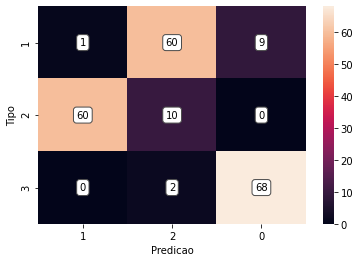

In [456]:
matriz_contigencia(kmeans_data["df_comparison"])

In [468]:
calculate_metrics(kmeans_data["df_comparison"], df)

Homogeneidade dos Clusters [0,1]: 0.6934607041029826
Completude dos Clusters [0,1]: 0.696395547296022
Fowlkes-Mallows [0,1]: 0.8106151670655933
Coeficiente de Silhouette [-1,1]: 0.4719337319126887
Coeficiente de Calinski-Harabasz: 375.8049613895007


## KMEANS Bisecting

In [409]:
bikmeans_data = {}

In [410]:
bikmeans_data['model'] = BisectingKMeans(n_clusters=3, random_state=42)
bikmeans_data['model'].fit(df)

bikmeans_data['model'].labels_

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [411]:
bikmeans_data['df_comparison'] = pd.DataFrame({
    "class": df_label,
    "cluster": bikmeans_data['model'].labels_
})
bikmeans_data['df_comparison'].head()

,class,cluster
0,1,0
1,1,1
2,1,1
3,1,1
4,1,0


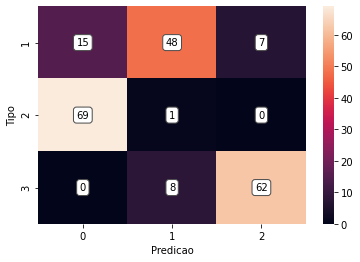

In [459]:
matriz_contigencia(bikmeans_data["df_comparison"], df)

In [469]:
calculate_metrics(bikmeans_data["df_comparison"], df)

Homogeneidade dos Clusters [0,1]: 0.6096161818623395
Completude dos Clusters [0,1]: 0.6165967525808717
Fowlkes-Mallows [0,1]: 0.7523245804813455
Coeficiente de Silhouette [-1,1]: 0.4183650552336077
Coeficiente de Calinski-Harabasz: 305.6416979474884


# Aglomerative Clustering 

### Por Máximo

In [413]:
aglomerative_max_data = {}

In [414]:
aglomerative_max_data['model'] = AgglomerativeClustering(n_clusters=3, linkage="complete")
aglomerative_max_data['model'].fit(df)

aglomerative_max_data['model'].labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [415]:
aglomerative_max_data['df_comparison'] = pd.DataFrame({
    "class": df_label,
    "cluster": aglomerative_max_data['model'].labels_
})
aglomerative_max_data['df_comparison'].head()

,class,cluster
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2


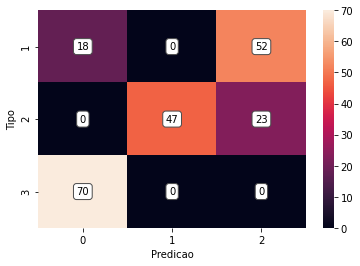

In [416]:
matriz_contigencia(aglomerative_max_data["df_comparison"])

In [470]:
calculate_metrics(aglomerative_max_data["df_comparison"], df)

Homogeneidade dos Clusters [0,1]: 0.6063655325391804
Completude dos Clusters [0,1]: 0.6241956655849628
Fowlkes-Mallows [0,1]: 0.7006848153145563
Coeficiente de Silhouette [-1,1]: 0.44140259950708405
Coeficiente de Calinski-Harabasz: 329.7892753794404


### Por Ward - Minimização de Variância entre Clusters

In [417]:
aglomerative_ward_data = {}

In [418]:
aglomerative_ward_data['model'] = AgglomerativeClustering(n_clusters=3, linkage="ward")
aglomerative_ward_data['model'].fit(df)

aglomerative_ward_data['model'].labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [419]:
aglomerative_ward_data['df_comparison'] = pd.DataFrame({
    "class": df_label,
    "cluster": aglomerative_ward_data['model'].labels_
})
aglomerative_ward_data['df_comparison'].head()

,class,cluster
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2


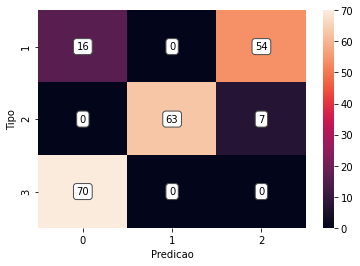

In [420]:
matriz_contigencia(aglomerative_ward_data["df_comparison"])

In [471]:
calculate_metrics(aglomerative_ward_data["df_comparison"], df)

Homogeneidade dos Clusters [0,1]: 0.7266916689197686
Completude dos Clusters [0,1]: 0.7352022993399162
Fowlkes-Mallows [0,1]: 0.809168863736427
Coeficiente de Silhouette [-1,1]: 0.449360862303228
Coeficiente de Calinski-Harabasz: 352.83550286580163


# DBSCAN

In [473]:
dbscan_data = {}

In [474]:
dbscan_data['model'] = DBSCAN(eps=0.95, min_samples=7)
# dbscan_data['model'] = DBSCAN(eps=0.7, min_samples=7)
dbscan_data['model'].fit(df)

set(dbscan_data['model'].labels_)

{-1, 0, 1}

In [475]:
dbscan_data['df_comparison'] = pd.DataFrame({
    "class": df_label,
    "cluster": dbscan_data['model'].labels_
})
dbscan_data['df_comparison'].head()

,class,cluster
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


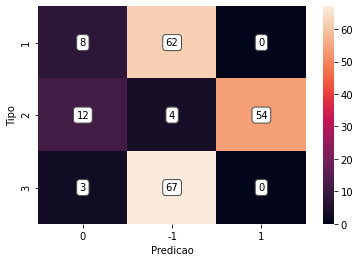

In [477]:
matriz_contigencia(dbscan_data["df_comparison"])

In [478]:
calculate_metrics(dbscan_data["df_comparison"], df)

Homogeneidade dos Clusters [0,1]: 0.4380762221416664
Completude dos Clusters [0,1]: 0.5464471849240069
Fowlkes-Mallows [0,1]: 0.6473578693337222
Coeficiente de Silhouette [-1,1]: 0.3828771120027297
Coeficiente de Calinski-Harabasz: 116.15183208541175


In [437]:
df_total = dbscan_data["df_comparison"].groupby(["class", "cluster"]).size().rename("total").reset_index()
df_total2 = df_total[df_total["cluster"] != -1]
cluster_map = df_total2.sort_values(["class", "cluster"]).groupby("class").last().reset_index().drop(columns=["total"]).rename(columns={"class": "pred_class"})

In [439]:
dbscan_data["df_comparison"] = dbscan_data["df_comparison"].merge(cluster_map)

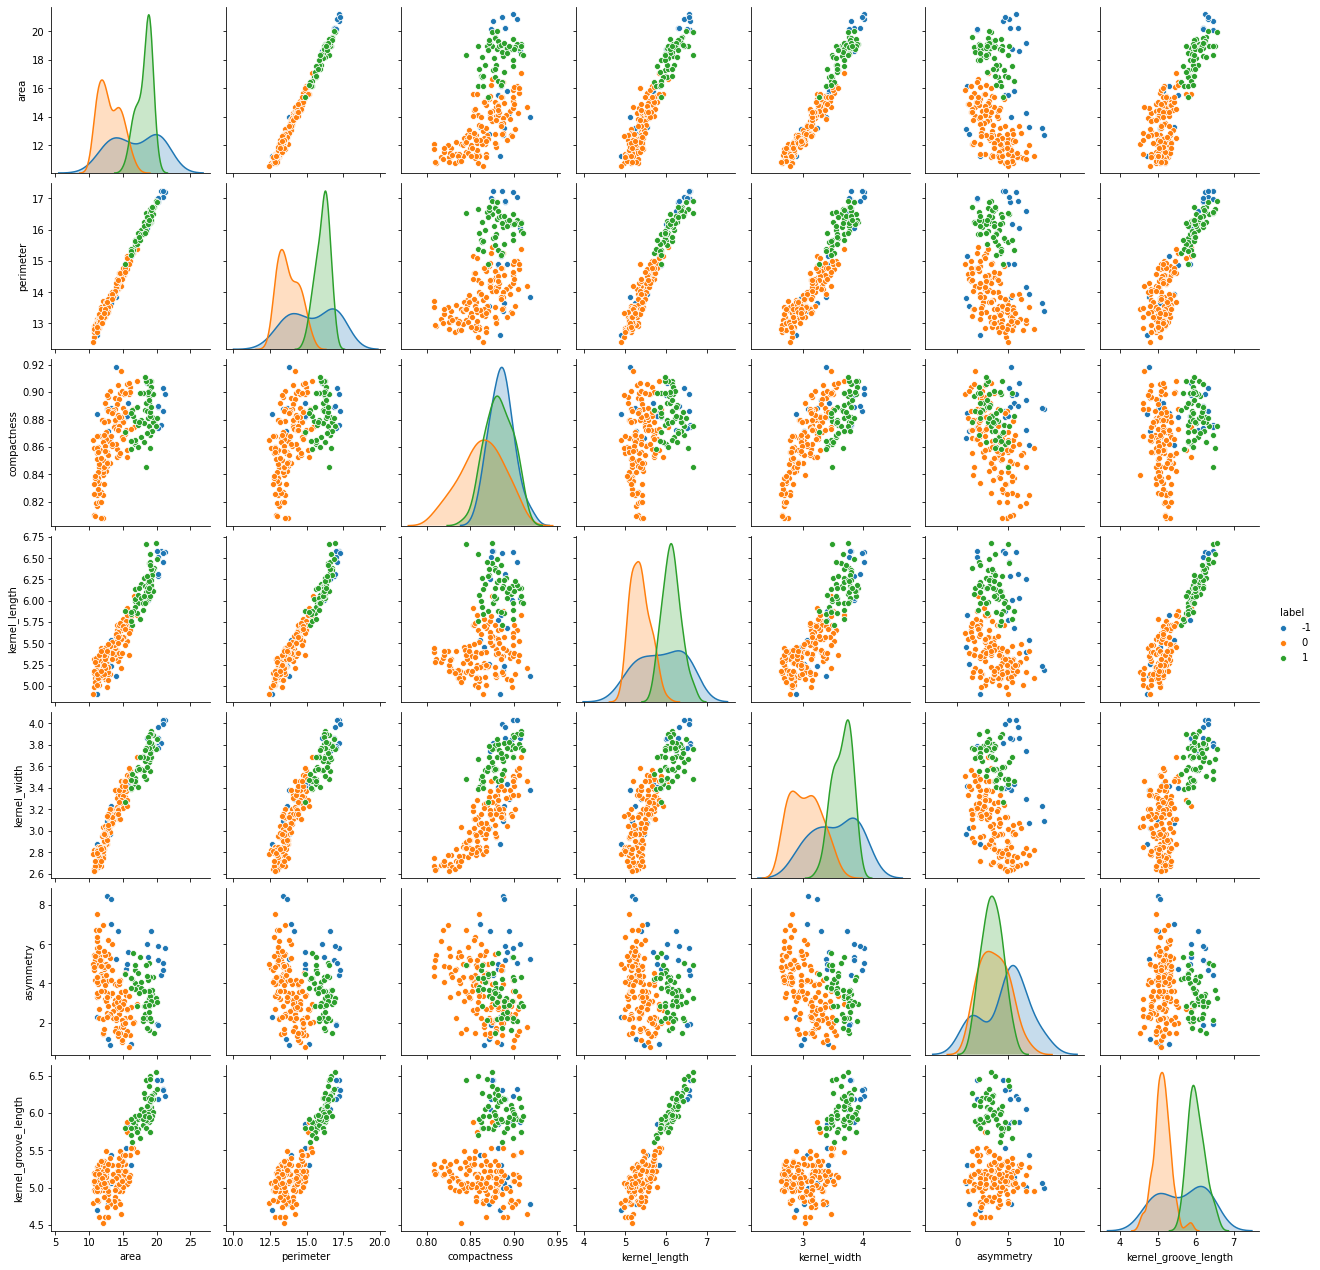

In [442]:
df2 = df.copy()
df2['label'] = dbscan_data["model"].labels_
sns.pairplot(df2, vars=df.columns, hue='label')

# Conclusões

### Métricas